In [21]:
from sqlplus import *
import matplotlib.pyplot as plt

In [43]:
with dbopen('db') as c:
    c.load('train.csv')
    c.load('test.csv')
    train = c.df('train')
    test = c.df('test')
    

Table train exists.
Table test exists.


In [28]:
with dbopen('db') as c:
    print(c.df('train').describe())
    print(c.df('train', cols='name, sex, age, ticket, cabin, embarked').describe())
    print(c.df('train', cols='sex').describe())
        
    print('NO. survived', end=': ')
    print(len(c.rows('train', where='survived=1')))
    print('NO. not survived', end=": ")
    print(len(c.rows('train', where='survived=0')))
    
    print("Male: ", end="")
    print(len(c.rows('train', where="sex='male'")))
    print("Female: ", end="")
    print(len(c.rows('train', where="sex='female'")))
    

       passengerid    survived      pclass       sibsp       parch        fare
count   891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000    8.000000    6.000000  512.329200
                                    name   sex  age    ticket cabin embarked
count                                891   891  891       891   891      891
unique                               891     2   89       681   148        4
top     Madigan, Miss. Margaret "Maggie"  male       CA. 2

In [ ]:
4

surv rate, male:  0.18890814558058924
surv rate, female:  0.3471337579617834


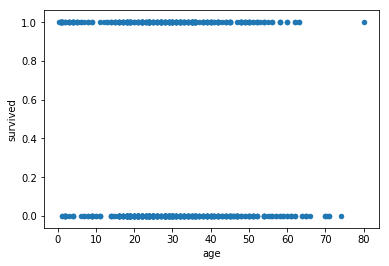

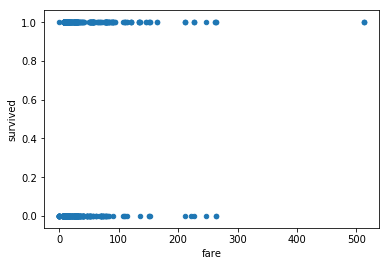

In [39]:
with dbopen('db') as c:
    c.df('train', where="isnum(age)").plot(kind="scatter", x="age", y="survived")
    c.df('train').plot(kind="scatter", x="fare", y="survived")
    # 성별 생존률
    male = c.rows('train', where='sex="male"')
    female = c.rows('train', where='sex="female"')
    print('surv rate, male: ', len(male.where('survived=1')) / len(male))
    print('surv rate, female: ', len(male.where('survived=1')) / len(female))
    plt.show()

In [40]:
with dbopen('db') as c:
    print(c.df('train').corr())

             passengerid  survived    pclass     sibsp     parch      fare
passengerid     1.000000 -0.005007 -0.035144 -0.057527 -0.001652  0.012658
survived       -0.005007  1.000000 -0.338481 -0.035322  0.081629  0.257307
pclass         -0.035144 -0.338481  1.000000  0.083081  0.018443 -0.549500
sibsp          -0.057527 -0.035322  0.083081  1.000000  0.414838  0.159651
parch          -0.001652  0.081629  0.018443  0.414838  1.000000  0.216225
fare            0.012658  0.257307 -0.549500  0.159651  0.216225  1.000000


In [91]:
with dbopen('db') as c:
    print(c.df('train', cols="age,parch, survived", where="isnum(age)").corr())

               age     parch  survived
age       1.000000 -0.189119 -0.077221
parch    -0.189119  1.000000  0.093317
survived -0.077221  0.093317  1.000000


In [118]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import statistics as st


with dbopen('db') as c:
    def minmax(val, seq):
        a, b = min(seq), max(seq)
        return (val - a) / (b - a)
    
    def prep(r, rs):
        r.sex = 1 if r.sex == 'male' else 0
        
        # age to median
        rs1 = rs.where(lambda r: r.age) 
        age_mid = st.median(rs1['age'])
        r.age = r.age or age_mid 
        # and min max scale
        
        rs2 = rs.where(lambda r: r.fare)
        r.age = minmax(r.age, rs1['age'])
        
        fare_mid = st.median(rs2['fare'])
        r.fare = r.fare or fare_mid
        r.fare = minmax(r.fare, rs2['fare'])
        
        r.s = 1 if r.embarked.lower() == 's' else 0
        r.c1 = 1 if r.embarked.lower() == 'c' else 0
        r.q = 1 if r.embarked.lower() == 'q' else 0
        
        r.a = 1 if r.cabin.startswith('A') else 0
        r.b = 1 if r.cabin.startswith('B') else 0
        r.c = 1 if r.cabin.startswith('C') else 0
        r.d = 1 if r.cabin.startswith('D') else 0
        r.e = 1 if r.cabin.startswith('E') else 0
        r.f = 1 if r.cabin.startswith('F') else 0
        r.g = 1 if r.cabin.startswith('G') else 0
        
        return r
    
    c.drop('train1')
    train = c.rows('train')
    for r in c.fetch('train'):
        c.insert(prep(r, train), 'train1')
        
    X = c.df('train1', cols='sex, age, fare, pclass, sibsp, parch, s, c1, q, a, b, c, d, e, f, g'    )
    y = c.df('train1', cols='survived')
    
    # clf = SGDClassifier()
    clf = SVC()
    # clf = LogisticRegression()
    
    clf.fit(X, y)
    print(cross_val_score(clf, X, y, cv=5, scoring="accuracy"))
    
    c.drop('test1')
    test = c.rows('test')
    for r in c.fetch('test'):
        c.insert(prep(r, test), 'test1')
    X_test = c.df('test1', cols='sex, age, fare, pclass, sibsp, parch, s, c1, q, a, b, c, d, e, f, g')
    
    
        
    result = []
    for i, x in enumerate(clf.predict(X_test), 892):
        r = Row()
        r.passengerid = i
        r.survived = x
        result.append(r)
    Rows(result).df().to_csv('result.csv')
        
        

[ 0.81564246  0.81005587  0.80337079  0.79775281  0.81355932]


In [103]:
clf.predict(X)

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1,

In [58]:
max([1,2,3])

3

In [84]:
''.startswith('a')

False